In [ ]:

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print("Libraries imported.")


Libraries imported.


In [ ]:

def generate_synthetic_data(n_per_class=200, random_seed=42):

    np.random.seed(random_seed)

    num_classes = 5
    means = np.array([
        [ 0,  0],
        [ 3,  3],
        [-3,  3],
        [ 3, -3],
        [-3, -3]
    ])
    cov = np.array([[0.8, 0.0],
                    [0.0, 0.8]])

    X_list = []
    y_list = []

    for c in range(num_classes):
        X_c = np.random.multivariate_normal(means[c], cov, size=n_per_class)
        y_c = np.full(n_per_class, c, dtype=int)

        X_list.append(X_c)
        y_list.append(y_c)

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

X, y = generate_synthetic_data(n_per_class=200)

print("X shape:", X.shape)   # (N, 2)
print("y shape:", y.shape)   # (N,)
print("Classes:", np.unique(y))


X shape: (1000, 2)
y shape: (1000,)
Classes: [0 1 2 3 4]


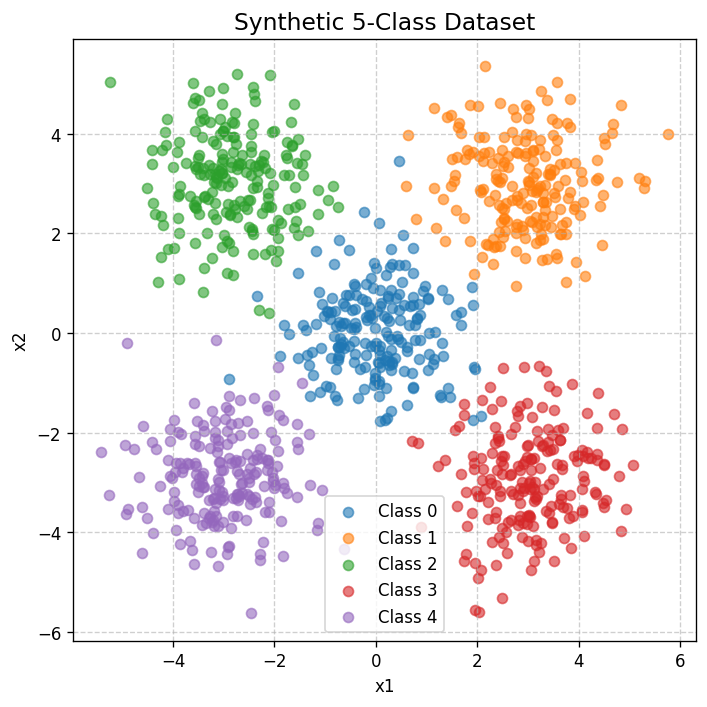

In [ ]:
plt.figure(figsize=(6, 6), dpi=120)
for c in np.unique(y):
    plt.scatter(X[y == c, 0], X[y == c, 1], alpha=0.6, label=f"Class {c}")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Synthetic 5-Class Dataset", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:

def train_test_split(X, y, test_ratio=0.3, seed=42):
    np.random.seed(seed)
    N = X.shape[0]
    indices = np.random.permutation(N)
    test_size = int(N * test_ratio)

    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

X_train_raw, y_train, X_test_raw, y_test = train_test_split(X, y, test_ratio=0.3)

# Standardize using training stats
mean = X_train_raw.mean(axis=0, keepdims=True)
std  = X_train_raw.std(axis=0, keepdims=True) + 1e-8

X_train = (X_train_raw - mean) / std
X_test  = (X_test_raw  - mean) / std

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 700
Test size : 300


In [ ]:

def print_class_distribution(name, labels):
    u, c = np.unique(labels, return_counts=True)
    print(f"{name} class distribution:")
    for cls, cnt in zip(u, c):
        print(f"  Class {cls}: {cnt} samples")
    print()

print_class_distribution("Train", y_train)
print_class_distribution("Test",  y_test)


Train class distribution:
  Class 0: 145 samples
  Class 1: 129 samples
  Class 2: 143 samples
  Class 3: 147 samples
  Class 4: 136 samples

Test class distribution:
  Class 0: 55 samples
  Class 1: 71 samples
  Class 2: 57 samples
  Class 3: 53 samples
  Class 4: 64 samples



In [ ]:

def one_hot(y, num_classes):
    N = y.shape[0]
    Y = np.zeros((N, num_classes))
    Y[np.arange(N), y] = 1.0
    return Y

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):

    z_shifted = z - np.max(z, axis=1, keepdims=True)  # stability
    exp_scores = np.exp(z_shifted)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

def cross_entropy_loss(y_true_one_hot, y_pred_proba):

    eps = 1e-12
    p = np.clip(y_pred_proba, eps, 1 - eps)
    loss = -np.mean(np.sum(y_true_one_hot * np.log(p), axis=1))
    return loss

def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [ ]:

class NeuralNetwork:
    def __init__(self, input_dim, hidden_dims, output_dim,
                 learning_rate=0.01, seed=42):
        np.random.seed(seed)
        h1, h2, h3 = hidden_dims

        # He initialization for ReLU layers
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2.0 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2.0 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2.0 / h3)
        self.b4 = np.zeros((1, output_dim))

        self.lr = learning_rate

    def forward(self, X):

        Z1 = X.dot(self.W1) + self.b1
        A1 = relu(Z1)

        Z2 = A1.dot(self.W2) + self.b2
        A2 = relu(Z2)

        Z3 = A2.dot(self.W3) + self.b3
        A3 = relu(Z3)

        Z4 = A3.dot(self.W4) + self.b4
        A4 = softmax(Z4)

        cache = {
            "X": X,
            "Z1": Z1, "A1": A1,
            "Z2": Z2, "A2": A2,
            "Z3": Z3, "A3": A3,
            "Z4": Z4, "A4": A4
        }
        return A4, cache

    def backward(self, y_true_one_hot, cache):

        X  = cache["X"]
        Z1, A1 = cache["Z1"], cache["A1"]
        Z2, A2 = cache["Z2"], cache["A2"]
        Z3, A3 = cache["Z3"], cache["A3"]
        Z4, A4 = cache["Z4"], cache["A4"]

        N = X.shape[0]

        # Output layer gradient (softmax + cross-entropy)
        dZ4 = (A4 - y_true_one_hot) / N       # (N, C)

        dW4 = A3.T.dot(dZ4)                   # (H3, C)
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # Layer 3
        dA3 = dZ4.dot(self.W4.T)              # (N, H3)
        dZ3 = dA3 * relu_derivative(Z3)       # (N, H3)

        dW3 = A2.T.dot(dZ3)                   # (H2, H3)
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Layer 2
        dA2 = dZ3.dot(self.W3.T)              # (N, H2)
        dZ2 = dA2 * relu_derivative(Z2)       # (N, H2)

        dW2 = A1.T.dot(dZ2)                   # (H1, H2)
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Layer 1
        dA1 = dZ2.dot(self.W2.T)              # (N, H1)
        dZ1 = dA1 * relu_derivative(Z1)       # (N, H1)

        dW1 = X.T.dot(dZ1)                    # (D, H1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        grads = {
            "dW1": dW1, "db1": db1,
            "dW2": dW2, "db2": db2,
            "dW3": dW3, "db3": db3,
            "dW4": dW4, "db4": db4
        }
        return grads

    def update_params(self, grads):

        self.W1 -= self.lr * grads["dW1"]
        self.b1 -= self.lr * grads["db1"]

        self.W2 -= self.lr * grads["dW2"]
        self.b2 -= self.lr * grads["db2"]

        self.W3 -= self.lr * grads["dW3"]
        self.b3 -= self.lr * grads["db3"]

        self.W4 -= self.lr * grads["dW4"]
        self.b4 -= self.lr * grads["db4"]

    def predict(self, X):
        probs, _ = self.forward(X)
        return np.argmax(probs, axis=1)


In [ ]:

num_classes = 5
input_dim   = X_train.shape[1]  # 2
hidden_dims = (64, 32, 16)
output_dim  = num_classes

nn = NeuralNetwork(input_dim, hidden_dims, output_dim,
                   learning_rate=0.01)

y_train_one_hot = one_hot(y_train, num_classes)
y_test_one_hot  = one_hot(y_test,  num_classes)

num_epochs = 200   # more epochs for higher accuracy
batch_size = 64

train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies  = []

N_train = X_train.shape[0]

for epoch in range(num_epochs):
    # Shuffle training data each epoch
    indices = np.random.permutation(N_train)
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    y_train_one_hot_shuffled = y_train_one_hot[indices]

    # Mini-batch training
    for start in range(0, N_train, batch_size):
        end = start + batch_size
        X_batch = X_train_shuffled[start:end]
        y_batch_one_hot = y_train_one_hot_shuffled[start:end]

        # Forward
        probs_batch, cache = nn.forward(X_batch)

        # Backward
        grads = nn.backward(y_batch_one_hot, cache)

        # Update parameters
        nn.update_params(grads)

    # ---- End of epoch: evaluate on full train & test ----
    train_probs, _ = nn.forward(X_train)
    test_probs,  _ = nn.forward(X_test)

    train_loss = cross_entropy_loss(y_train_one_hot, train_probs)
    test_loss  = cross_entropy_loss(y_test_one_hot,  test_probs)

    y_train_pred = np.argmax(train_probs, axis=1)
    y_test_pred  = np.argmax(test_probs,  axis=1)

    train_acc = compute_accuracy(y_train, y_train_pred)
    test_acc  = compute_accuracy(y_test,  y_test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train loss = {train_loss:.4f}, Train acc = {train_acc:.4f} | "
              f"Test loss = {test_loss:.4f}, Test acc = {test_acc:.4f}")


Epoch   1/200 | Train loss = 1.2598, Train acc = 0.5400 | Test loss = 1.2097, Test acc = 0.5533
Epoch  20/200 | Train loss = 0.3163, Train acc = 0.9114 | Test loss = 0.2788, Test acc = 0.9400
Epoch  40/200 | Train loss = 0.1991, Train acc = 0.9614 | Test loss = 0.1775, Test acc = 0.9733
Epoch  60/200 | Train loss = 0.1337, Train acc = 0.9771 | Test loss = 0.1208, Test acc = 0.9800
Epoch  80/200 | Train loss = 0.0965, Train acc = 0.9800 | Test loss = 0.0886, Test acc = 0.9833
Epoch 100/200 | Train loss = 0.0751, Train acc = 0.9843 | Test loss = 0.0702, Test acc = 0.9867
Epoch 120/200 | Train loss = 0.0626, Train acc = 0.9871 | Test loss = 0.0597, Test acc = 0.9867
Epoch 140/200 | Train loss = 0.0547, Train acc = 0.9871 | Test loss = 0.0532, Test acc = 0.9867
Epoch 160/200 | Train loss = 0.0494, Train acc = 0.9871 | Test loss = 0.0488, Test acc = 0.9867
Epoch 180/200 | Train loss = 0.0456, Train acc = 0.9871 | Test loss = 0.0458, Test acc = 0.9867
Epoch 200/200 | Train loss = 0.0429, Tra

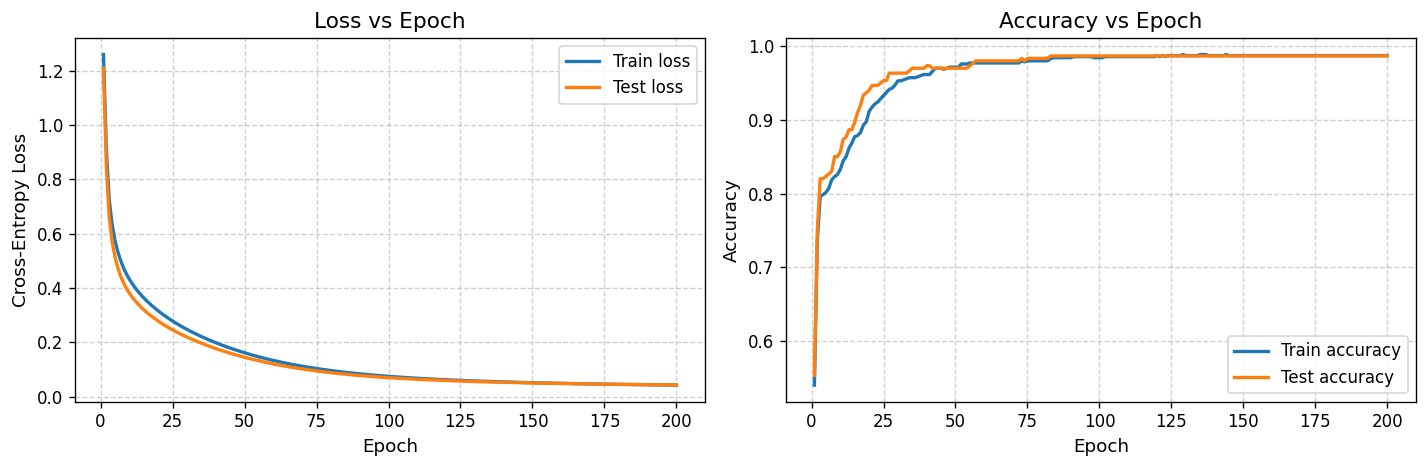

In [ ]:

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 4), dpi=120)

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train loss', linewidth=2)
plt.plot(epochs, test_losses,  label='Test loss',  linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Cross-Entropy Loss', fontsize=11)
plt.title('Loss vs Epoch', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train accuracy', linewidth=2)
plt.plot(epochs, test_accuracies,  label='Test accuracy',  linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Accuracy vs Epoch', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def precision_recall_f1(cm):
    num_classes = cm.shape[0]
    precision = np.zeros(num_classes)
    recall    = np.zeros(num_classes)
    f1        = np.zeros(num_classes)

    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        precision[c] = tp / (tp + fp + 1e-12)
        recall[c]    = tp / (tp + fn + 1e-12)
        f1[c]        = 2 * precision[c] * recall[c] / (precision[c] + recall[c] + 1e-12)

    return precision, recall, f1

# Final predictions on test set
y_test_pred = nn.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred, num_classes)
precision, recall, f1 = precision_recall_f1(cm)

print("Confusion Matrix (rows = true, columns = predicted):")
print(cm)
print()

for c in range(num_classes):
    print(f"Class {c}: "
          f"Precision={precision[c]:.4f}, "
          f"Recall={recall[c]:.4f}, "
          f"F1={f1[c]:.4f}")

overall_accuracy = compute_accuracy(y_test, y_test_pred)
macro_precision  = precision.mean()
macro_recall     = recall.mean()
macro_f1         = f1.mean()

print("\nOverall Test Accuracy:", overall_accuracy)
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1:", macro_f1)


Confusion Matrix (rows = true, columns = predicted):
[[52  0  2  1  0]
 [ 0 71  0  0  0]
 [ 0  0 57  0  0]
 [ 0  0  0 53  0]
 [ 1  0  0  0 63]]

Class 0: Precision=0.9811, Recall=0.9455, F1=0.9630
Class 1: Precision=1.0000, Recall=1.0000, F1=1.0000
Class 2: Precision=0.9661, Recall=1.0000, F1=0.9828
Class 3: Precision=0.9815, Recall=1.0000, F1=0.9907
Class 4: Precision=1.0000, Recall=0.9844, F1=0.9921

Overall Test Accuracy: 0.9866666666666667
Macro-averaged Precision: 0.9857430503736702
Macro-averaged Recall: 0.9859659090908925
Macro-averaged F1: 0.9857003547018961


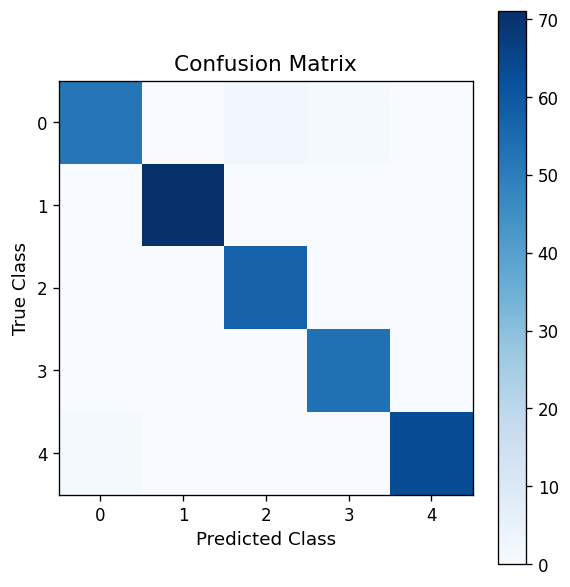

In [ ]:
plt.figure(figsize=(5, 5), dpi=120)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix', fontsize=13)
plt.xlabel('Predicted Class', fontsize=11)
plt.ylabel('True Class', fontsize=11)
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:

correct = np.sum(y_test_pred == y_test)
total   = y_test.shape[0]
accuracy_percent = (correct / total) * 100.0

print(f"Correctly predicted {correct} samples out of {total}, "
      f"overall accuracy: {accuracy_percent:.1f} %")


Correctly predicted 296 samples out of 300, overall accuracy: 98.7 %


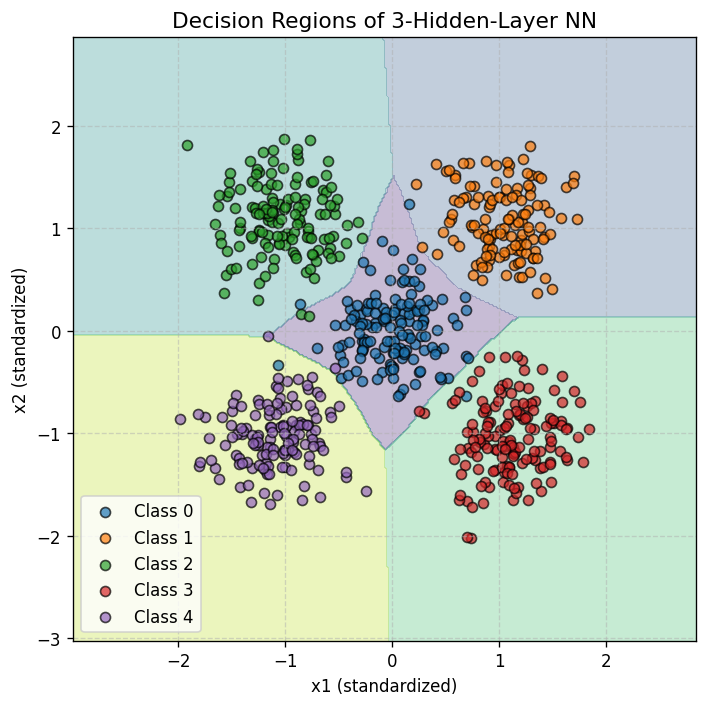

In [ ]:

x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300)
)

grid_points = np.c_[xx1.ravel(), xx2.ravel()]
grid_pred = nn.predict(grid_points).reshape(xx1.shape)

plt.figure(figsize=(6, 6), dpi=120)
plt.contourf(xx1, xx2, grid_pred, alpha=0.3, levels=np.arange(-0.5, 5, 1))
for c in np.unique(y_train):
    plt.scatter(X_train[y_train == c, 0], X_train[y_train == c, 1],
                edgecolor='k', label=f"Class {c}", alpha=0.7)
plt.xlabel("x1 (standardized)")
plt.ylabel("x2 (standardized)")
plt.title("Decision Regions of 3-Hidden-Layer NN", fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
